# Simulating density errors in wide-band FMCW and freeboard retrievals

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pyproj import Proj

C = 299792458 #Vacuum speed of light

# Plot settings
axis_value_size = 12
axis_label_size = 14

In [2]:
# W99 Constants and methods
# I've adapted Stefan Hendricks' approach to W99 estimates 
# Full credit to Stefan for code within this cell
# see https://github.com/shendric/pysiral

sd_coefs = np.array([
        [28.01, 0.1270, -1.1833, -0.1164, -0.0051, 0.0243, 7.6, -0.06, 0.07, 4.6],
        [30.28, 0.1056, -0.5908, -0.0263, -0.0049, 0.0044, 7.9, -0.06, 0.08, 5.5],
        [33.89, 0.5486, -0.1996, 0.0280, 0.0216, -0.0176, 9.4, -0.04, 0.10, 6.2],
        [36.80, 0.4046, -0.4005, 0.0256, 0.0024, -0.0641, 9.4, -0.09, 0.09, 6.1],
        [36.93, 0.0214, -1.1795, -0.1076, -0.0244, -0.0142, 10.6, -0.21, 0.09, 6.3],
        [36.59, 0.7021, -1.4819, -0.1195, -0.0009, -0.0603, 14.1, -0.16, 0.12, 8.1],
        [11.02, 0.3008, -1.2591, -0.0811, -0.0043, -0.0959, 9.5, 0.02, 0.10, 6.7],
        [4.64, 0.3100, -0.6350, -0.0655, 0.0059, -0.0005, 4.6, -0.01, 0.05, 3.3],
        [15.81, 0.2119, -1.0292, -0.0868, -0.0177, -0.0723, 7.8, -0.03, 0.06, 3.8],
        [22.66, 0.3594, -1.3483, -0.1063, 0.0051, -0.0577, 8.0, -0.08, 0.06, 4.0],
        [25.57, 0.1496, -1.4643, -0.1409, -0.0079, -0.0258, 7.9, -0.05, 0.07, 4.3],
        [26.67, -0.1876, -1.4229, -0.1413, -0.0316, -0.0029, 8.2, -0.06, 0.07, 4.8]])

swe_coefs = np.array([
        [8.37, -0.0270, -0.3400, -0.0319, -0.0056, -0.0005, 2.5, -0.005, 0.024, 1.6],
        [9.43, 0.0058, -0.1309, 0.0017, -0.0021, -0.0072, 2.6, -0.007, 0.028, 1.8],
        [10.74, 0.1618, 0.0276, 0.0213, 0.0076, -0.0125, 3.1, 0.007, 0.032, 2.1],
        [11.67, 0.0841, -0.1328, 0.0081, -0.0003, -0.0301, 3.2, -0.013, 0.032, 2.1],
        [11.80, -0.0043, -0.4284, -0.0380, -0.0071, -0.0063, 3.5, -0.047, 0.033, 2.2],
        [12.48, 0.2084, -0.5739, -0.0468, -0.0023, -0.0253, 4.9, -0.030, 0.044, 2.9],
        [4.01, 0.0970, -0.4930, -0.0333, -0.0026, -0.0343, 3.5, 0.008, 0.037, 2.4],
        [1.08, 0.0712, -0.1450, -0.0155, 0.0014, -0.0000, 1.1, -0.001, 0.012, 0.8],
        [3.84, 0.0393, -0.2107, -0.0182, -0.0053, -0.0190, 2.0, -0.003, 0.016, 1.0],
        [6.24, 0.1158, -0.2803, -0.0215, 0.0015, -0.0176, 2.3, -0.005, 0.021, 1.4],
        [7.54, 0.0567, -0.3201, -0.0284, -0.0032, -0.0129, 2.4, -0.000, 0.023, 1.5],
        [8.00, -0.0540, -0.3650, -0.0362, -0.0112, -0.0035, 2.5, -0.003, 0.024, 1.5]])

def get_sd_coefs(month):
    return sd_coefs[month-1, 0:6]

def get_swe_coefs(month):
    return swe_coefs[month-1, 0:6]

def get_snow_depth(month, l2x, l2y):
        sd = get_sd_coefs(month)
        snow_depth = sd[0] + sd[1]*l2x + sd[2]*l2y + sd[3]*l2x*l2y + sd[4]*l2x*l2x + sd[5]*l2y*l2y
        snow_depth *= 0.01
        return snow_depth
    
def get_snow_density(snow_depth, month, l2x, l2y):
        # get snow water equivalent coefs
        swe = get_swe_coefs(month)
        snow_water_equivalent = swe[0] + swe[1]*l2x + swe[2]*l2y + swe[3]*l2x*l2y + swe[4]*l2x*l2x + swe[5]*l2y*l2y
        snow_water_equivalent *= 0.01

        # Convert sd and swe to snow density
        snow_density = snow_water_equivalent/snow_depth*water_density
        return snow_density
    
earth_radius = 6371000.8
water_density = 1024.0

In [3]:
def snow_refractive_index(snow_density, perm_ice = 3.15):
    perm_snow = (1 + 0.51 * snow_density/1000) ** 3
    n_snow = np.sqrt(perm_snow) # Permittivity to refractive index
    return n_snow

In [4]:
def c_in_snow(snow_density, C = 299792458):
    return C*((1+0.51*snow_density/1000)**(-1.5))

In [5]:
#Load all the profile summary data
site_path = './output/sites'
summary_files = []
for i in os.listdir(site_path):
    if os.path.isfile(os.path.join(site_path,i)) and 'Summary' in i:
        summary_files.append(os.path.join(site_path, i))
        
summary_list = []
for filename in summary_files:
    df = pd.read_pickle(filename)
    summary_list.append(df)

summary_df = pd.concat(summary_list, axis=0, ignore_index=True)
summary_df.head(1)

,file_name,site_name,ice_type,latitude,longitude,penetration,density_f,density_h,density_r,fraction_f,fraction_h,fraction_r,mean_weighted_density
0,S34M1840,Alert_2_MYI,MYI,83.983345,-66.351509,501.816095,351.309129,233.568333,319.221392,0.368159,0.537313,0.094527,285.012248


In [6]:
# A few bad profiles to drop where the pack is thin
summary_df.drop(summary_df[summary_df['file_name'] == 'S34M0399'].index, inplace = True)
summary_df.drop(summary_df[summary_df['file_name'] == 'S34M0401'].index, inplace = True)

In [7]:
#Load all the profile measurement
site_path = './output/sites'
data_files = []
for i in os.listdir(site_path):
    if os.path.isfile(os.path.join(site_path,i)) and 'Data' in i:
        data_files.append(os.path.join(site_path, i))
        
data_list = []
for filename in data_files:
    df = pd.read_pickle(filename)
    data_list.append(df)

data_df = pd.concat(data_list, axis=0, ignore_index=True)
data_df.head(1)

,relative_height,l,force_median,layer_type,layer_label,site_name,file_name,density
0,0.0,0.492178,0.110858,1,R,Alert_2_MYI,S34M1840,214.357532


In [8]:
static_density = 300 # in kg m-3
bin_height = 0.0025
profile_names = summary_df.file_name.unique()

delta_h_static = []
delta_h_w99 = []
delta_h_smp = []

c_cs_w99 = []
c_cs_smp = []

w99_rho_latlon = []

p = Proj(proj="stere", lat_0=90, lon_0=-90, lat_ts=70)


for profile in profile_names:
    profile_df = data_df[data_df['file_name'] == profile]
    profile_summary = summary_df[summary_df['file_name'] == profile_df['file_name'].iloc[0]]
    x, y =p(profile_summary.longitude.values[0],profile_summary.latitude.values[0])
    w99x = x / (earth_radius * np.pi / 180)
    w99y = y / (earth_radius * np.pi / 180)
    w99_sd = get_snow_depth(4, w99x, w99y)
    w99_rho = get_snow_density(w99_sd, 4, w99x, w99y)
    
    w99_rho_latlon.append(w99_rho)
                   
    profile_heights = profile_df['relative_height']/1000
    profile_density =  profile_df['density']
    bin_height_array = np.repeat(bin_height,len(profile_heights))
    profile_thickness = profile_heights.max()
    
    c_cs_w99.append(c_in_snow(w99_rho)/C)
    c_cs_smp.append((c_in_snow(profile_density)/C).mean())
    
    delta_h_w99.append(profile_thickness*(C/c_in_snow(w99_rho)-1))
    delta_h_static.append(profile_thickness*(C/c_in_snow(static_density)-1))
    delta_h_smp.append((bin_height_array*(C/c_in_snow(profile_density)-1)).sum())
    

In [9]:
summary_df['site_name'].unique()

array(['Alert_2_MYI', 'Alert_3_MYI', 'Alert_5_MYI', 'Alert_6_MYI',
       'Alert_7_MYI', 'Alert_8_MYI', 'Eureka_1_FYI', 'Eureka_2_FYI',
       'Eureka_3_FYI', 'Eureka_4_FYI', 'Eureka_5_MYI', 'Eureka_6_FYI',
       'Eureka_7_FYI', 'Eureka_8_MYI'], dtype=object)

In [10]:
summary_df['delta_h_smp'] = np.array(delta_h_smp)
summary_df['delta_h_static'] = np.array(delta_h_static)
summary_df['delta_h_w99'] = np.array(delta_h_static)
summary_df['delta_h_error'] = summary_df['delta_h_smp'] - summary_df['delta_h_w99'] 
summary_df['w99_rho'] = w99_rho_latlon
summary_df['c_cs_w99'] = c_cs_w99
summary_df['c_cs_smp'] = c_cs_smp
summary_df['delta_h_error_static'] = summary_df['delta_h_smp'] - summary_df['delta_h_static']

In [11]:
# Campaign names were missing...
campaign = np.repeat('E', len(summary_df))
campaign[summary_df['site_name'].str.contains('Alert')] = 'A'
summary_df['campaign'] = campaign

In [12]:
swe_w99 = summary_df['w99_rho'] * summary_df['penetration']/1000
swe_smp= summary_df['mean_weighted_density'] * summary_df['penetration']/1000

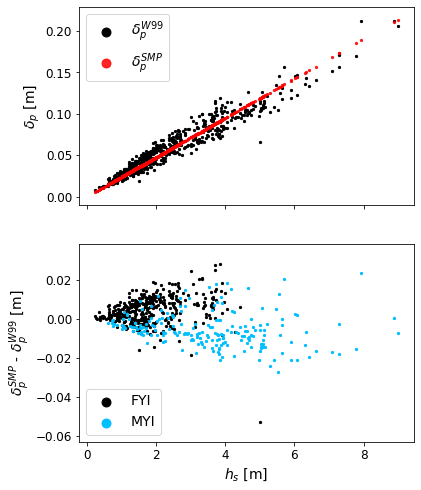

In [13]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,8))
ax1.tick_params(axis='both', which='major', labelsize=axis_value_size)
ax2.tick_params(axis='both', which='major', labelsize=axis_value_size)

ax1.scatter(summary_df['penetration']/100, summary_df['delta_h_smp'], 
            color = 'k', s  = 5, label = '$\delta_{p}^{W99}$')
ax1.scatter(summary_df['penetration']/100, summary_df['delta_h_w99'], 
            color = 'r', s  = 5, alpha = 0.85, label = '$\delta_{p}^{SMP}$')
ax1.set_ylabel('$\delta_{p}$ [m]' ,fontsize=axis_label_size)

ax2.scatter(summary_df[summary_df['ice_type'] == 'FYI']['penetration']/100, 
            summary_df[summary_df['ice_type'] == 'FYI']['delta_h_smp'] \
            - summary_df[summary_df['ice_type'] == 'FYI']['delta_h_w99'],
            color = 'k', s = 5, label = 'FYI')


ax2.scatter(summary_df[summary_df['ice_type'] == 'MYI']['penetration']/100, 
            summary_df[summary_df['ice_type'] == 'MYI']['delta_h_smp'] \
            - summary_df[summary_df['ice_type'] == 'MYI']['delta_h_w99'],
            color = 'deepskyblue', s = 5, label = 'MYI')


ax2.set_ylabel('$\delta_{p}^{SMP}$ - $\delta_{p}^{W99}$ [m]',fontsize=axis_label_size)

ax2.set_xlabel('$h_{s}$ [m]' ,fontsize=axis_label_size)
ax1.legend(fontsize=axis_label_size, markerscale=4)
ax2.legend(loc = 3 ,fontsize=axis_label_size, markerscale=4)
#lgnd2.legendHandles[0]._legmarker.set_markersize(6)

f.savefig('./output/figures/Fig11_Applicaiton.png', format='png')

In [14]:
np.round(summary_df.groupby(['campaign', 'ice_type'])['delta_h_smp'].describe(), 3)*100

count  mean  std  min  25%  50%   75%   max
campaign ice_type                                               
A        MYI        6300.0   9.2  2.8  2.8  6.9  9.5  10.7  15.6
E        FYI       40200.0   4.8  2.4  0.7  3.1  4.3   6.1  11.9
         MYI       14800.0   7.1  4.1  1.2  3.8  6.6   9.8  21.2

In [15]:
np.round(summary_df.groupby(['campaign', 'ice_type'])['delta_h_w99'].describe(), 3)*100

count  mean  std  min  25%  50%   75%   max
campaign ice_type                                               
A        MYI        6300.0   9.4  2.6  2.5  7.8  9.3  11.5  14.3
E        FYI       40200.0   4.3  2.1  0.6  2.9  4.0   5.4  11.8
         MYI       14800.0   7.7  4.4  1.4  4.1  6.8  10.7  21.4

In [16]:
np.round(summary_df.groupby(['campaign', 'ice_type'])['delta_h_w99'].describe(), 3)*100

count  mean  std  min  25%  50%   75%   max
campaign ice_type                                               
A        MYI        6300.0   9.4  2.6  2.5  7.8  9.3  11.5  14.3
E        FYI       40200.0   4.3  2.1  0.6  2.9  4.0   5.4  11.8
         MYI       14800.0   7.7  4.4  1.4  4.1  6.8  10.7  21.4

In [17]:
np.round(summary_df.groupby(['campaign', 'ice_type'])['delta_h_error'].mean(), 3)*100

campaign  ice_type
A         MYI        -0.3
E         FYI         0.5
          MYI        -0.6
Name: delta_h_error, dtype: float64

In [18]:
np.round((round(summary_df.groupby(['campaign', 'ice_type'])['delta_h_error'].mean(),3)*100/(np.round(summary_df.groupby(['campaign', 'ice_type'])['penetration'].mean(), 3)/10))*100, 1)

campaign  ice_type
A         MYI        -0.8
E         FYI         2.7
          MYI        -1.8
dtype: float64

In [19]:
np.round(summary_df.groupby(['ice_type'])['delta_h_error'].mean(),3)

ice_type
FYI    0.005
MYI   -0.005
Name: delta_h_error, dtype: float64

In [20]:
np.round(summary_df.groupby(['ice_type'])['delta_h_error'].describe(), 3)*100

,count,mean,std,min,25%,50%,75%,max
ice_type,,,,,,,,
FYI,40200.0,0.5,0.7,-5.3,0.0,0.5,0.9,2.8
MYI,21100.0,-0.5,0.9,-2.7,-1.1,-0.6,-0.1,2.4


In [21]:
np.round(summary_df.groupby(['campaign', 'ice_type'])['delta_h_error'].describe(), 3)*100

count  mean  std  min  25%  50%  75%  max
campaign ice_type                                             
A        MYI        6300.0  -0.3  1.0 -2.1 -1.0 -0.5  0.3  2.0
E        FYI       40200.0   0.5  0.7 -5.3  0.0  0.5  0.9  2.8
         MYI       14800.0  -0.6  0.8 -2.7 -1.1 -0.7 -0.2  2.4

In [22]:
summary_df.groupby(['campaign', 'ice_type'])['latitude'].describe()

count       mean       std        min        25%  \
campaign ice_type                                                     
A        MYI        63.0  84.852626  1.022082  83.442131  83.983414   
E        FYI       402.0  79.980447  0.072977  79.842346  79.965073   
         MYI       148.0  79.910790  0.084050  79.812958  79.813622   

                         50%        75%        max  
campaign ice_type                                   
A        MYI       84.857788  85.444664  86.284805  
E        FYI       79.983921  80.021599  80.080154  
         MYI       79.982334  79.982895  79.983727

In [23]:
summary_df.groupby(['campaign', 'ice_type'])['w99_rho'].describe()

count        mean       std         min         25%  \
campaign ice_type                                                        
A        MYI        63.0  317.308566  2.834172  313.279269  314.942495   
E        FYI       402.0  298.121467  0.446058  297.291961  297.961102   
         MYI       148.0  297.668950  0.480318  297.109629  297.113700   

                          50%         75%         max  
campaign ice_type                                      
A        MYI       317.444840  319.031614  321.147020  
E        FYI       298.133275  298.386184  298.737010  
         MYI       298.076770  298.081086  298.087535

In [24]:
np.round(summary_df.groupby(['campaign', 'ice_type'])['delta_h_w99'].describe(), 3)

count   mean    std    min    25%    50%    75%    max
campaign ice_type                                                        
A        MYI        63.0  0.094  0.026  0.025  0.078  0.093  0.115  0.143
E        FYI       402.0  0.043  0.021  0.006  0.029  0.040  0.054  0.118
         MYI       148.0  0.077  0.044  0.014  0.041  0.068  0.107  0.214

In [25]:
summary_df.head(1)

,file_name,site_name,ice_type,latitude,longitude,penetration,density_f,density_h,density_r,fraction_f,...,mean_weighted_density,delta_h_smp,delta_h_static,delta_h_w99,delta_h_error,w99_rho,c_cs_w99,c_cs_smp,delta_h_error_static,campaign
0,S34M1840,Alert_2_MYI,MYI,83.983345,-66.351509,501.816095,351.309129,233.568333,319.221392,0.368159,...,285.012248,0.113617,0.119033,0.119033,-0.005416,314.942294,0.799769,0.816895,-0.005416,A


In [26]:
bins = np.arange(100, 1000, 10)
summary_bin = pd.cut(summary_df['penetration'], bins)

np.round(summary_df.groupby(['campaign'])['c_cs_smp'].describe(),3)

pen_mean = summary_df.groupby(['campaign', 'ice_type'])['penetration'].mean()
print(np.round(pen_mean))

campaign  ice_type
A         MYI         397.0
E         FYI         182.0
          MYI         326.0
Name: penetration, dtype: float64


In [27]:
sample_range = 10
depth_ref = pen_mean[1]
d_pen_min = summary_df[(summary_df['penetration']<=depth_ref+sample_range) &(summary_df['penetration']>=depth_ref-sample_range)]['delta_h_smp'].min()
d_pen_max = summary_df[(summary_df['penetration']<=depth_ref+sample_range) &(summary_df['penetration']>=depth_ref-sample_range)]['delta_h_smp'].max()
d_pen_mean = summary_df[(summary_df['penetration']<=depth_ref+sample_range) &(summary_df['penetration']>=depth_ref-sample_range)]['delta_h_smp'].mean()
d_pen_std = summary_df[(summary_df['penetration']<=depth_ref+sample_range) &(summary_df['penetration']>=depth_ref-sample_range)]['delta_h_smp'].std()

np.round(d_pen_max- d_pen_min,3) # in m

0.03

In [28]:
sample_range = 50
d_pen_min = summary_df[(summary_df['penetration']<=depth_ref+sample_range) &(summary_df['penetration']>=depth_ref-sample_range)]['delta_h_w99'].min()
d_pen_max = summary_df[(summary_df['penetration']<=depth_ref+sample_range) &(summary_df['penetration']>=depth_ref-sample_range)]['delta_h_w99'].max()
d_pen_max- d_pen_min

0.023806646711717398

In [29]:
binned_pen_min = summary_df.groupby(summary_bin)['delta_h_smp'].min()
binned_pen_max = summary_df.groupby(summary_bin)['delta_h_smp'].max()
binned_pen_range = binned_pen_max.values - binned_pen_min.values

In [30]:
# Correlations between SMP classification properties and delta_h
summary_df.groupby('ice_type').corr()['delta_h_smp']

ice_type                       
FYI       latitude                -0.040973
          longitude               -0.062501
          penetration              0.955644
          density_f                0.510240
          density_h                0.403445
          density_r                0.233891
          fraction_f               0.496308
          fraction_h               0.120684
          fraction_r              -0.752807
          mean_weighted_density    0.276701
          delta_h_smp              1.000000
          delta_h_static           0.955919
          delta_h_w99              0.955919
          delta_h_error            0.511244
          w99_rho                 -0.035908
          c_cs_w99                 0.035886
          c_cs_smp                -0.273859
          delta_h_error_static     0.511244
MYI       latitude                 0.244107
          longitude                0.212065
          penetration              0.976645
          density_f                0.446163


In [31]:
# Differences in wave speed from layered measurements
c_in_slab = c_in_snow(summary_df['density_r'].mean())
c_in_other = c_in_snow((summary_df['density_f'].mean()  + summary_df['density_h'].mean() )/2)
np.round((((c_in_slab - c_in_other) / c_in_slab) *100),1)

-3.0